In [3]:
from google.colab import drive
drive.mount("/content/drive")
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing Libraries and Data Preparation**

In [4]:
%%capture
!pip install ipykernel
!pip install --upgrade nbformat
!pip install neuralforecast
!pip install statsforecast

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from tqdm.notebook import tqdm_notebook
from time import time

# Statsforecast
from statsforecast import StatsForecast as sf


# Neuralforecast
from neuralforecast import NeuralForecast

import torch

import matplotlib.pyplot as plt
# Plotting params

plot_params = {
    "font.size": 15,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 15,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.titlesize": 18,
    "figure.dpi": 150,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False}

plt.style.use("ggplot")
plt.rcParams.update(plot_params)
# plt.rcParams["font.size"] = 15
# # plt.rcParams['axes.facecolor'] = 'white'
# # Set the background color to white
# plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams['axes.facecolor'] = 'white'

# # Only show major gridlines
# plt.rcParams['axes.grid'] = True
# plt.rcParams['grid.linestyle'] = '-'
# plt.rcParams['grid.linewidth'] = 0.5

# # Only show left and bottom axes
# plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.spines.right'] = False
COLORS = list(sns.color_palette())

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
%%time
df = pd.read_csv("drive/MyDrive/data/clean_train_nixtla.csv", parse_dates = ["date"], index_col = 0)
# test = pd.read_csv("drive/MyDrive/data/test_nitxla.csv", parse_dates = ["date"], index_col = 0)
df.head()

CPU times: user 543 ms, sys: 86.3 ms, total: 629 ms
Wall time: 755 ms


,date,store_item,sales
0,2013-01-01,10_1,14
1,2013-01-01,6_47,5
2,2013-01-01,6_46,23
3,2013-01-01,6_45,34
4,2013-01-01,6_44,17


### **Selecting Subset of Data**

For simplicity & speed, we will only keep (randomly) data from the store number 9

In [8]:
df = df.loc[(df["store_item"].str.startswith('9'))].sort_values(["date", "store_item"]).reset_index(drop = True)
df.head()

,date,store_item,sales
0,2013-01-01,9_1,11
1,2013-01-01,9_10,45
2,2013-01-01,9_11,35
3,2013-01-01,9_12,35
4,2013-01-01,9_13,47


In [9]:
# Rename columns to match the NixtlaVerse's expectations
# The 'store_item' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'sales' becomes 'y' representing the target variable we want to forecast
# Y_df = dataset.query('unique_id.str.startswith("6_46")').copy()

Y_df = df.copy()
# Y_df = Y_df.reset_index()
Y_df = Y_df.rename(columns={
    'store_item': 'unique_id',
    'date': 'ds',
    'sales': 'y'
})
Y_df['y'] = Y_df['y'].astype(int)
# Convert the 'ds' column to datetime format to ensure proper handling of date-related operations in subsequent steps
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
# Convert the 'id' column to string type
Y_df['unique_id'] = Y_df['unique_id'].astype(str)
Y_df.tail()

,ds,unique_id,y
91295,2017-12-31,9_50,65
91296,2017-12-31,9_6,57
91297,2017-12-31,9_7,78
91298,2017-12-31,9_8,92
91299,2017-12-31,9_9,50


In [10]:
# horizon is the number of days in the future for which we will make a forecast
horizon = 30

In [116]:
Y_df.head()

,ds,unique_id,y
0,2013-01-01,9_1,11
1,2013-01-01,9_10,45
2,2013-01-01,9_11,35
3,2013-01-01,9_12,35
4,2013-01-01,9_13,47


In [12]:
Y_df_test = Y_df.groupby('unique_id').tail(horizon).copy()
Y_df_train = Y_df.drop(Y_df_test.index)
# Optional for further experiment
# Y_df_test.loc[:, 'y'] = 0
# Y_df_full = pd.concat([Y_df_train, Y_df_test]).sort_values(['unique_id', 'ds'], ignore_index=True)
# Y_df_full.head()

In [115]:
Y_df_train.head()

,ds,unique_id,y
0,2013-01-01,9_1,11
1,2013-01-01,9_10,45
2,2013-01-01,9_11,35
3,2013-01-01,9_12,35
4,2013-01-01,9_13,47


# **Modeling**

## **Importing Modules**

In [14]:
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoNBEATS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, sCRPS

## **Setting Configuratons**

In [15]:
level = np.arange(0, 100 , 2)
qs = [[50-lv/2, 50 + lv/2] if lv!=0 else [50] for lv in level]
quantiles = np.sort(np.concatenate(qs) / 100)

# Previously I set max_steps to be 1000, which makes training last for 30 min with TPU
config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3, 48*5]),              # Length of input window
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": tune.choice([5 * [[64, 64]], 5 * [[128, 128]],
                              5 * [[256, 256]] , 5 * [[512, 512]] ]), # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4], 5*[8],
                                      [16, 8, 4, 1, 1],
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "pooling_mode": tune.choice(['MaxPool1d', 'AvgPool1d']),
    "scaler_type": tune.choice([None]),                         # Scaler type
    "max_steps": tune.choice([100]),                               # Max number of training iterations
    "batch_size": tune.choice([32, 64, 128, 256]),                  # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),       # Number of windows in batch
    "val_check_steps": 50,
    "random_seed": tune.randint(1, 20)                             # Random seed
}

## **Defining Models**

In [16]:
model = AutoNHITS(h=horizon, config=config_nhits,
                  search_alg=HyperOptSearch(),
                  loss=MQLoss(quantiles = quantiles), # You can set a accuracy metric if not concern the probabilistic aspect
                  # loss = sCRPS(quantiles = quantiles),
                  # valid_loss = sCRPS(quantiles = quantiles),
                  num_samples=20)

## **Model Training**

### **Model Fitting**

In [ ]:
nf = NeuralForecast(models=[model], freq='D')
nf.fit(df=Y_df_train, val_size=60)

### **Forecasting based on Fitted Model**

In [102]:
fcst_df = nf.predict()

Predicting: 0it [00:00, ?it/s]

## **Plotting Forecasts**

In [106]:
fcst_df = fcst_df.reset_index().set_index(['unique_id', 'ds'])
fcst_df = fcst_df.rename(columns = lambda x : str(x)[:-2])
fcst_df.columns = fcst_df.columns.str.replace('-medi', '')
fcst_df = fcst_df.reset_index().set_index('unique_id')

In [112]:
fcst_df.head()

,ds,AutoNHITS-lo-98,AutoNHITS-lo-96,AutoNHITS-lo-94,AutoNHITS-lo-92,AutoNHITS-lo-90,AutoNHITS-lo-88,AutoNHITS-lo-86,AutoNHITS-lo-84,AutoNHITS-lo-82,...,AutoNHITS-hi-80,AutoNHITS-hi-82,AutoNHITS-hi-84,AutoNHITS-hi-86,AutoNHITS-hi-88,AutoNHITS-hi-90,AutoNHITS-hi-92,AutoNHITS-hi-94,AutoNHITS-hi-96,AutoNHITS-hi-98
unique_id,,,,,,,,,,,,,,,,,,,,,
9_1,2017-12-02,14.905617,16.211760,17.140556,17.547224,18.003208,18.432816,18.693430,18.546318,18.910328,...,29.934933,29.876244,30.081062,30.983236,31.096249,31.382366,32.162254,32.412067,32.896355,34.312038
9_1,2017-12-03,15.811539,17.477524,18.511642,18.809406,19.353100,19.221409,19.379036,20.002886,19.996437,...,31.387236,31.602280,31.618336,32.216312,31.943623,32.808533,32.919838,34.372147,34.837093,36.328110
9_1,2017-12-04,8.049446,9.566611,9.954490,10.787945,11.011785,11.112605,11.156525,11.544371,12.307761,...,20.925674,21.599567,21.710249,21.796507,21.846165,22.497711,22.531765,23.408056,23.900805,25.627682
9_1,2017-12-05,11.698906,12.873528,13.234003,14.264502,13.990343,14.780457,14.834289,15.365164,15.597587,...,25.182217,25.484171,25.843187,26.005650,26.498272,26.659657,27.704536,26.895473,28.544163,28.997026
9_1,2017-12-06,10.724828,11.490437,13.027788,13.339389,13.547268,13.903798,14.542968,14.113815,14.571641,...,24.004137,24.702950,24.764107,24.869001,25.494808,25.550476,26.313616,26.841936,26.947294,28.862204


In [68]:
Y_df

,ds,unique_id,y
0,2013-01-01,9_1,11
1,2013-01-01,9_10,45
2,2013-01-01,9_11,35
3,2013-01-01,9_12,35
4,2013-01-01,9_13,47
...,...,...,...
91295,2017-12-31,9_50,65
91296,2017-12-31,9_6,57
91297,2017-12-31,9_7,78
91298,2017-12-31,9_8,92


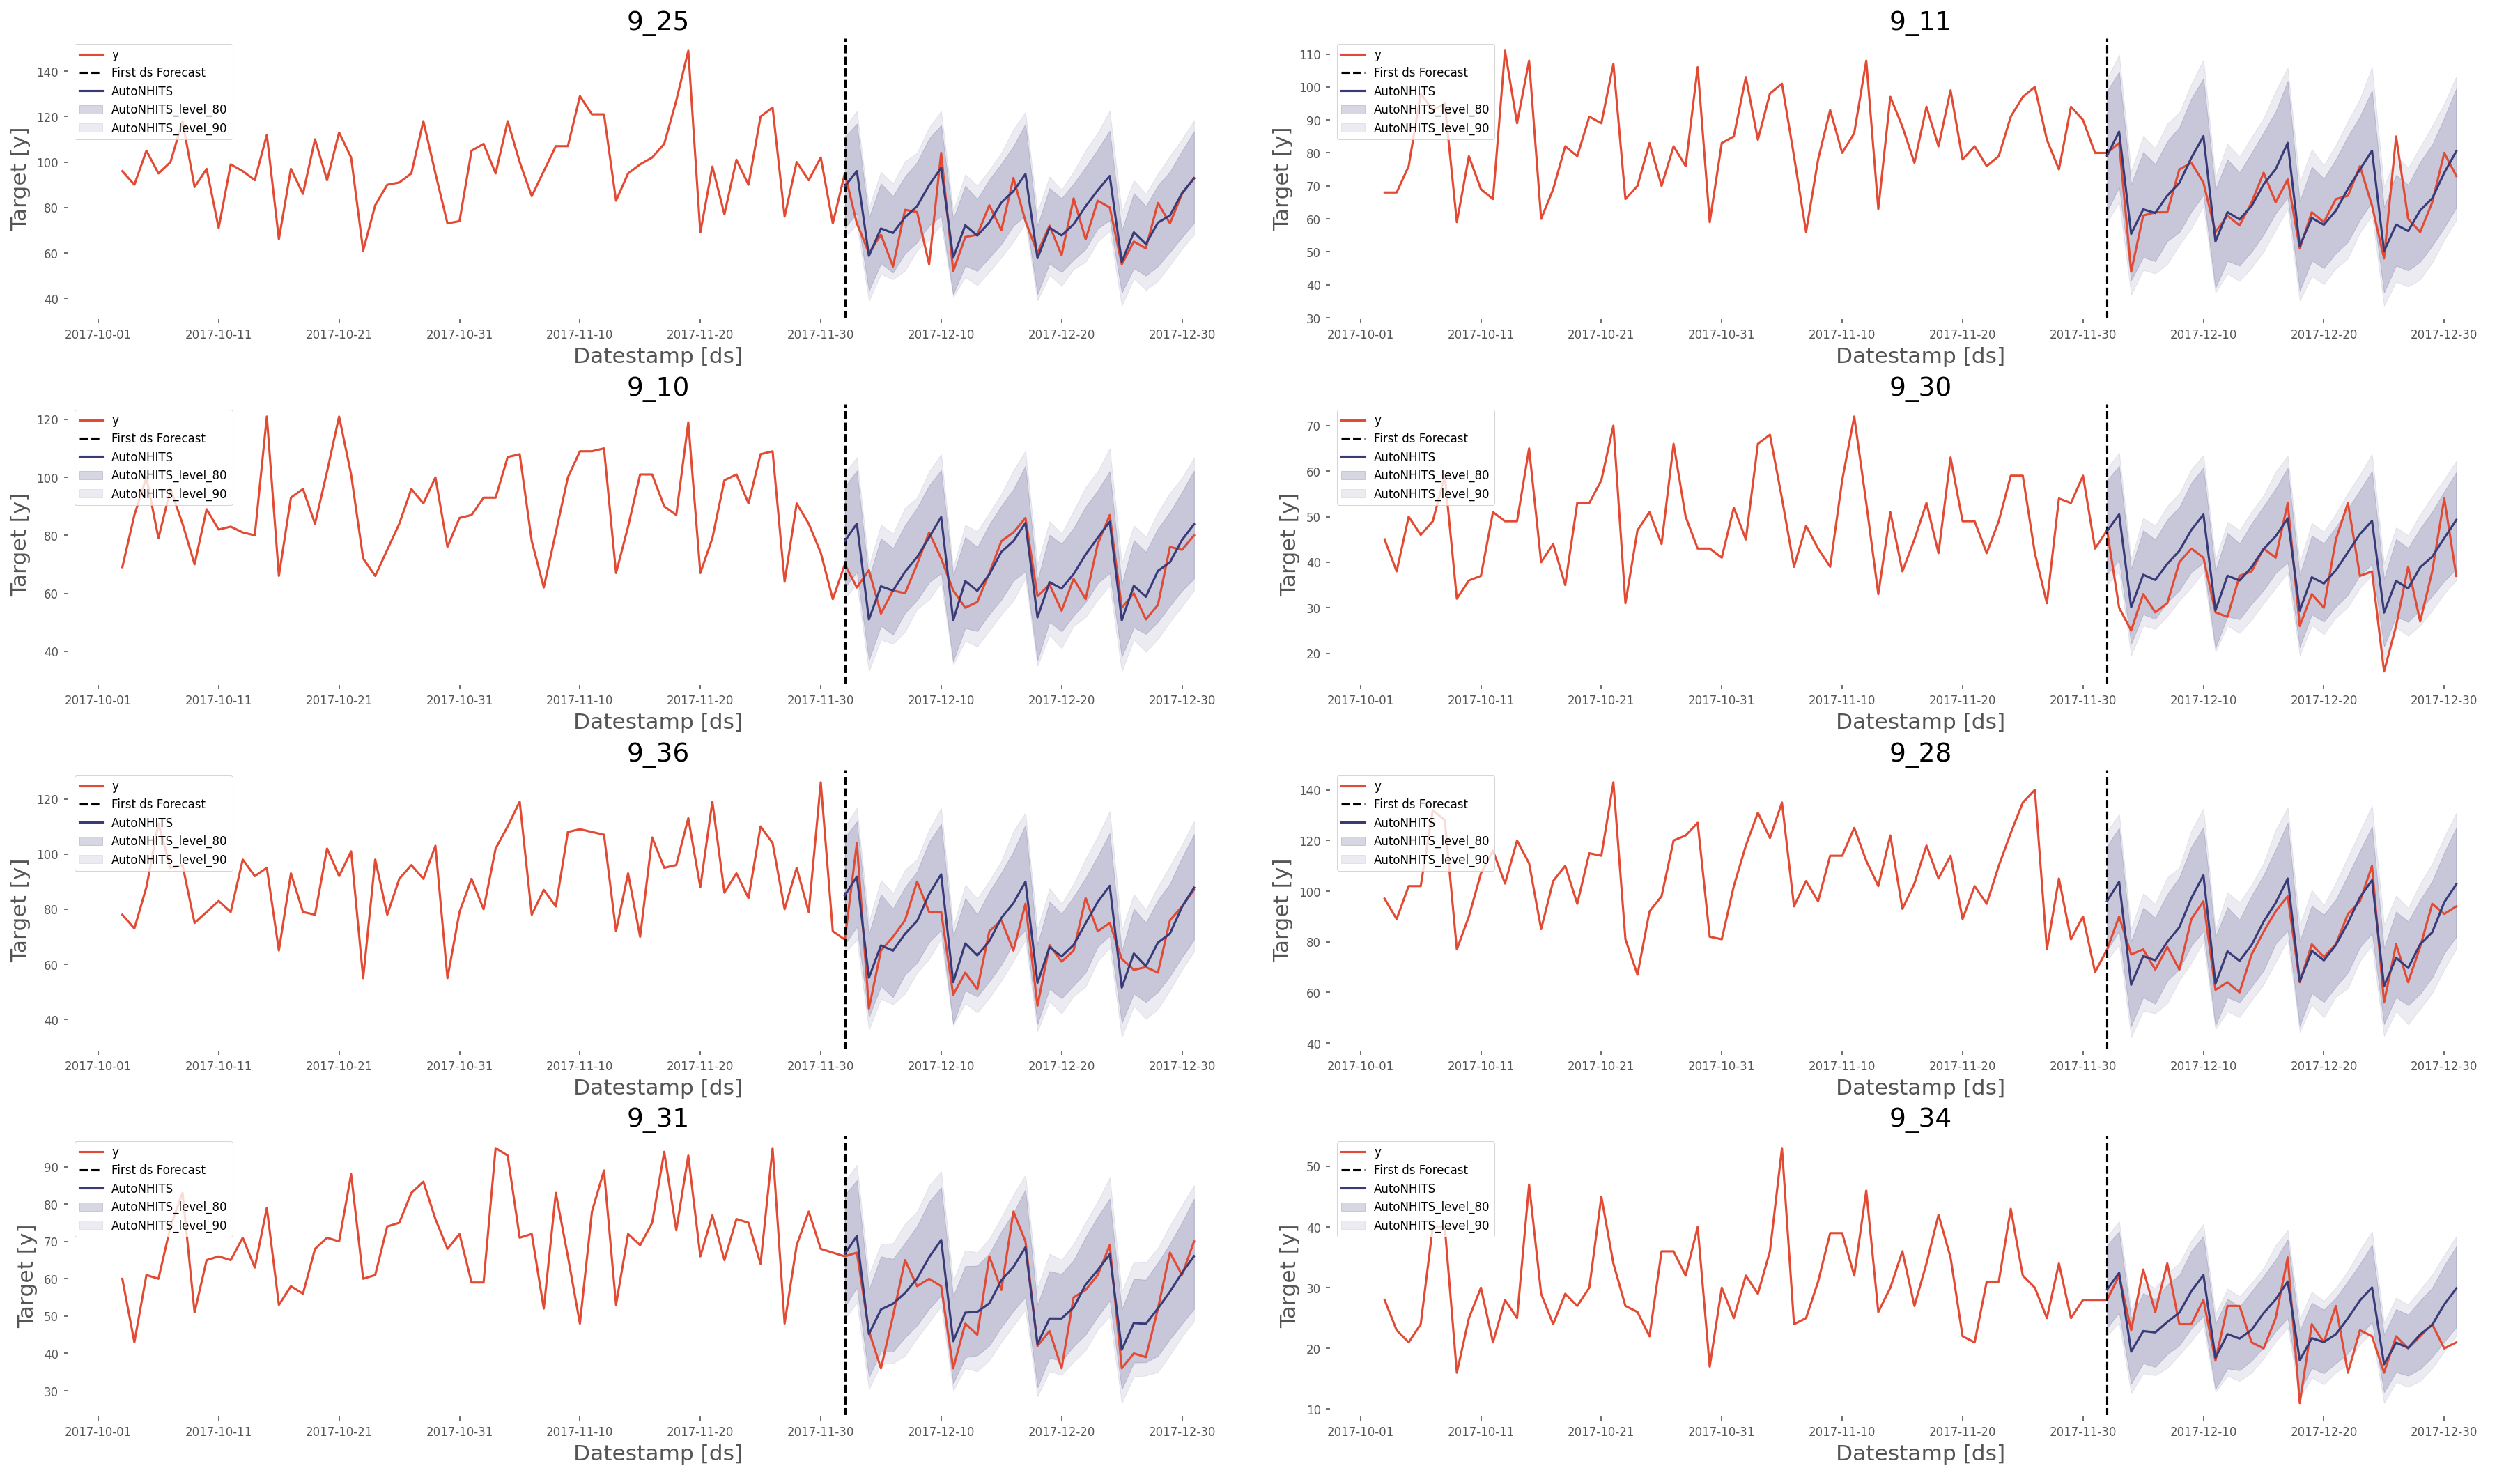

In [114]:
sf.plot(Y_df, fcst_df, engine='matplotlib', max_insample_length=30 * 3, level=[80, 90])